In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split 

In [5]:
dog_item = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_item.csv')

# dog_user2, dog_data2  -> KFOLD (k=5) 용 데이터 
dog_user = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_user_kfold.csv')
dog_ratings = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_data_kfold.csv')

dog_ratings = dog_ratings.drop('regdt', axis=1)

In [6]:
dog_ratings

,m_no,goodsno,point,pet_age,dogname
0,29471,259,5.0,2.0,푸들
1,29471,256,5.0,2.0,푸들
2,29471,258,5.0,2.0,푸들
3,29471,35564,3.0,9.0,푸들
4,29471,3042,5.0,1.0,푸들
...,...,...,...,...,...
99995,714257,16341,5.0,2.0,진돗개
99996,714257,13679,5.0,2.0,푸들
99997,714257,12665,5.0,2.0,진돗개
99998,714257,31517,5.0,2.0,푸들


In [7]:
dog_item.set_index('goodsno', inplace=True)

In [8]:
def RMSE(y_true, y_pred):
  '''
  실제 데이터(y_true)와 예측 데이터(y_pred)를 입력받아 
  이에 대한 RMSE 값을 계산하여 반환 
  '''
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [9]:
X = dog_ratings.copy()

X.columns

Index(['m_no', 'goodsno', 'point', 'pet_age', 'dogname'], dtype='object')

In [10]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n=5):
    '''
    df col: img_path, label
    '''
    kfold = StratifiedKFold(n_splits=kfold_n)
    
    # 클래스 비율 고려하여 Fold 별로 데이터 분리 
    X = np.array(df) 
    y = df.m_no.values 
    
    datas = [] 
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx].copy().reset_index(drop=True) 
        
        datas.append((train_df, test_df))
    return datas

datas = split_df(X)

In [11]:
def CF_basic(m_no, goodsno):
  '''
  기본 협업 필터링 알고리즘 
  '''
  if goodsno in rating_matrix: 
    sim_scores = user_similarity[m_no].copy()   # 사용자 유사도 복사 
    item_ratings = rating_matrix[goodsno].copy()   # 영화 평점 값 복사 
    none_rating_idx = item_ratings[item_ratings.isnull()].index   # 주어진 제품에 대해 평가를 하지 않은 사용자들의 인덱스 저장 
    item_ratings = item_ratings.dropna()   # 제품 평점 값이 NULL인 데이터 삭제 
    sim_scores = sim_scores.drop(none_rating_idx)   # 주어진 제품을 평가하지 않은 사용자와의 유사도 제거  
    mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)   # 각 사용자에 대해 평점을 유사도로 가중 평균한 예측치 구함  
  else:   # raint_matrix에 item 번호가 없는 경우 
    mean_rating = 3.0
  return mean_rating 

In [12]:
def CF_knn(m_no, goodsno, neighbor_size=0):
  if goodsno in rating_matrix: 
    sim_scores = user_similarity[m_no].copy()
    item_ratings = rating_matrix[goodsno].copy()
    none_rating_idx = item_ratings[item_ratings.isnull()].index 
    item_ratings = item_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)

    # neighbor_size가 지정되지 않은 경우 
    if neighbor_size == 0: 
      mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001) 
    else:  # neighbor size가 지정된 경우 
      if len(sim_scores) > 1:   # 해당 영화를 평가한 다른 사용자 수가 매우 작으면 계산에 문제가 생기는 것을 방지 
        # print(type(neighbor_size))
        neighbor_size = min(neighbor_size, len(sim_scores))   # 지정한 neighbor_size 값, 해당 영화를 평가한 총 사용자 수 중 작은 것을 이웃으로 설정 
        sim_scores = np.array(sim_scores)   # DataFrame 형태의 sim_scores를 numpy 배열로 변환 
        item_ratings = np.array(item_ratings)  
        user_idx = np.argsort(sim_scores)   # 다른 사용자들을 유사도 순서대로 정렬 
        sim_scores = sim_scores[user_idx][-neighbor_size:]   # 가장 유사도가 높은 neighbor_size(k)명의 사용자 선정 
        item_ratings = item_ratings[user_idx][-neighbor_size:]   # 선정된 k명의 사용자의 주어진 영화에 대한 평점 추출 
        mean_rating = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)   #  선정된 이웃 사용자의 해당 영화에 대한 평점을 유사도로 가중한 평점평균값 계산 
      else:
        mean_rating = 3.0 
  else:
    mean_rating = 3.0 
  return mean_rating 

In [13]:
def CF_knn_bias(m_no, goodsno, neighbor_size=0):
  if goodsno in rating_bias:   # 주어진 영화가 rating bias에 있으면 
    sim_scores = user_similarity[m_no].copy()
    item_ratings = rating_bias[goodsno].copy()   # 해당 영화의 평점(rating_matrx) 대신 평점편차(rating_bias)를 복사해서 가져옴 
    none_rating_idx = item_ratings[item_ratings.isnull()].index   # 주어진 영화에 대해 평가를 하지 않은 사용자들의 인덱스 저장
    item_ratings = item_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)
 
    if neighbor_size == 0:   # Neighbor size가 지정되지 않은 경우
      prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
      prediction = prediction + rating_mean[m_no]   # 예측치를 평점편차로 구했기 떄문에 최종 예측값을 위해 해당 사용자의 평균을 더함 
    else:    # Neighbor size가 지정된 경우 
      if len(sim_scores) > 1: 
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores) 
        item_ratings = np.array(item_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        item_ratings = item_ratings[user_idx][-neighbor_size:]
        prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
        prediction = prediction + rating_mean[m_no]
      else: 
        prediction = rating_mean[m_no]
  else:
    prediction = rating_mean[m_no]
  return prediction 

In [14]:
# 공통으로 평가한 제품 수와 서
# 예측값이 1이하이면 1로, 5이상이면 5로 수정
def CF_knn_bias_sig(m_no, goodsno, neighbor_size=0):
  if goodsno in rating_bias: 
    sim_scores = user_similarity[m_no].copy()
    item_ratings = rating_bias[goodsno].copy()
    no_rating = item_ratings.isnull()    # 현재 영화에 대해 평가하지 않은 사용자를 True로 표시 
    common_counts = counts[m_no]    # 현재 사용자와 공통으로 평가한 영화의 수를 가져옴 
    low_significance = common_counts < SIG_LEVEL   # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 작은 사용자를 True로 표시 
    # 사용자 중에 해당 영화를 평가하지 않았거나, 평가를 했어도 공통으로 평가한 영화의 수가 SIG_LEVEL보다 적은 사용자를 표시 
    none_rating_idx = item_ratings[no_rating | low_significance].index    # |: or 연산자
    item_ratings = item_ratings.drop(none_rating_idx)
    sim_scores = sim_scores.drop(none_rating_idx)
    
    if neighbor_size == 0:   # Neighbor size가 지정되지 않은 경우
      prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
      prediction = prediction + rating_mean[m_no] 
      if prediction > 5:
        prediction = 5 
      elif prediction < 1:
        prediction = 1 
    else: 
      if len(sim_scores) > MIN_RATINGS:   # 현재 영화를 평가한 사용자 수가 미리 정한 최소 사용자 수보다 큰 경우에만 예측 진행 
        neighbor_size = min(neighbor_size, len(sim_scores))
        sim_scores = np.array(sim_scores) 
        item_ratings = np.array(item_ratings)
        user_idx = np.argsort(sim_scores)
        sim_scores = sim_scores[user_idx][-neighbor_size:]
        item_ratings = item_ratings[user_idx][-neighbor_size:]
        prediction = np.dot(sim_scores, item_ratings) / (sim_scores.sum() + 0.0001)
        prediction = prediction + rating_mean[m_no]
        if prediction > 5: 
          prediction = 5 
        elif prediction < 1: 
          prediction = 1 
      else: 
        prediction = rating_mean[m_no]
  else:
    prediction = rating_mean[m_no]
  return prediction 

In [15]:
def score(model, fold, neighbor_size=-1): 
  ''' 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  if neighbor_size == -1: 
    id_pairs = zip(datas[fold][1]['m_no'], datas[fold][1]['goodsno'])    # id_pairs: (sno1, goodsno1), (sno2, goodsno2), (sno3, goods_no3) 쌍을 얻음 
    y_pred = np.array([model(user, item) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_true = np.array(datas[fold][1]['point'])   # test 데이터의 실제 값 저장 
    return RMSE(y_true, y_pred)
  else:  
    id_pairs = zip(datas[fold][1]['m_no'], datas[fold][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
    y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
    y_true = np.array(datas[fold][1]['point'])   # test 데이터의 실제 값 저장 
    return RMSE(y_true, y_pred)  

In [17]:
datas[3][0].pivot(index='m_no', columns='goodsno', values='point')

goodsno,14,20,21,23,31,36,38,69,70,71,...,87098,87556,87644,87654,87659,87660,87663,87664,87683,87731
m_no,,,,,,,,,,,,,,,,,,,,,
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
datas[2][0].pivot(index='m_no', columns='goodsno', values='point')

goodsno,14,20,21,23,31,36,38,69,70,71,...,87015,87033,87034,87098,87102,87292,87556,87654,87731,87733
m_no,,,,,,,,,,,,,,,,,,,,,
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
rating_matrix = datas[2][0].pivot(index='m_no', columns='goodsno', values='point')   # train_data를 이용하여 matrix 생성  
matrix_dummy = rating_matrix.copy().fillna(0)   # 코사인 유사도 계산을 위해 rating_matrix의 NaN 값을 0으로 변경 
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

results = []
index = [] 

for neighbor_size in range(10, 201, 10):    # 이웃 수를 바꿔가며 RMSE 값 계산 
  index.append(neighbor_size)
  results.append(score(CF_knn, 2, neighbor_size))   # 3번째 데이터셋 
  print('Neighbor size=%d: RMSE: %.4f' % (neighbor_size, score(CF_knn, 2, neighbor_size)))

Neighbor size=10: RMSE: 0.9333
Neighbor size=20: RMSE: 0.9203
Neighbor size=30: RMSE: 0.9166
Neighbor size=40: RMSE: 0.9155
Neighbor size=50: RMSE: 0.9147
Neighbor size=60: RMSE: 0.9144
Neighbor size=70: RMSE: 0.9141
Neighbor size=80: RMSE: 0.9141
Neighbor size=90: RMSE: 0.9139
Neighbor size=100: RMSE: 0.9139
Neighbor size=110: RMSE: 0.9140
Neighbor size=120: RMSE: 0.9140
Neighbor size=130: RMSE: 0.9140
Neighbor size=140: RMSE: 0.9140
Neighbor size=150: RMSE: 0.9139
Neighbor size=160: RMSE: 0.9139
Neighbor size=170: RMSE: 0.9139
Neighbor size=180: RMSE: 0.9139
Neighbor size=190: RMSE: 0.9140
Neighbor size=200: RMSE: 0.9140


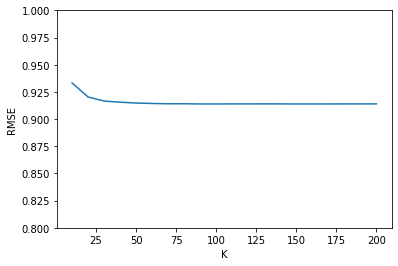

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(index, [result for result in results])
plt.ylim(0.8, 1)
plt.xlabel('K')   # 90
plt.ylabel('RMSE')
plt.show()

In [ ]:
for neighbor_size in range(80,100, 1):
  print(neighbor_size)

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
rating_matrix = datas[2][0].pivot(index='m_no', columns='goodsno', values='point')   # train_data를 이용하여 matrix 생성  
matrix_dummy = rating_matrix.copy().fillna(0)   # 코사인 유사도 계산을 위해 rating_matrix의 NaN 값을 0으로 변경 
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

results2 = []
index2 = [] 

for neighbor_size in range(80,100, 1):    # 이웃 수를 바꿔가며 RMSE 값 계산 
  index2.append(neighbor_size)
  results2.append(score(CF_knn, 2, neighbor_size))   # 3번째 데이터셋 
  print('Neighbor size=%d: RMSE: %.4f' % (neighbor_size, score(CF_knn, 2, neighbor_size)))

Neighbor size=80: RMSE: 0.9141
Neighbor size=81: RMSE: 0.9140
Neighbor size=82: RMSE: 0.9140
Neighbor size=83: RMSE: 0.9140
Neighbor size=84: RMSE: 0.9140
Neighbor size=85: RMSE: 0.9140
Neighbor size=86: RMSE: 0.9140
Neighbor size=87: RMSE: 0.9140
Neighbor size=88: RMSE: 0.9139
Neighbor size=89: RMSE: 0.9139
Neighbor size=90: RMSE: 0.9139
Neighbor size=91: RMSE: 0.9139
Neighbor size=92: RMSE: 0.9139
Neighbor size=93: RMSE: 0.9139
Neighbor size=94: RMSE: 0.9139
Neighbor size=95: RMSE: 0.9139
Neighbor size=96: RMSE: 0.9139
Neighbor size=97: RMSE: 0.9139
Neighbor size=98: RMSE: 0.9139
Neighbor size=99: RMSE: 0.9139


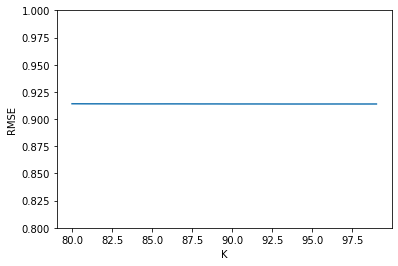

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(index2, [result2 for result2 in results2])
plt.ylim(0.8, 1)
plt.xlabel('K')   # 90
plt.ylabel('RMSE')
plt.show()

In [21]:
kfold_n = 5 

basic_CF_kfold = [] 
knn_CF_kfold = []
knn_bias_CF_kfold = []
knn_bias_sig_CF_kfold = []

for fold in range(0, kfold_n):
  rating_matrix = datas[fold][0].pivot(index='m_no', columns='goodsno', values='point')   # train_data를 이용하여 matrix 생성  
  matrix_dummy = rating_matrix.copy().fillna(0)   # 코사인 유사도 계산을 위해 rating_matrix의 NaN 값을 0으로 변경 
  user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
  user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

  basic_CF_kfold.append(score(CF_basic, fold))
  knn_CF_kfold.append(score(CF_knn, fold, 30))

  rating_mean = rating_matrix.mean(axis=1)   # full matrix에서 각 사용자의 평점 평균을 구함 
  rating_bias = (rating_matrix.T - rating_mean).T   # 영화 평점과 각 사용자의 평균과의 차이(평점편차)를 구함 

  knn_bias_CF_kfold.append(score(CF_knn_bias, fold, 90))

  SIG_LEVEL = 3
  MIN_RATINGS = 10 

  rating_binary1 = np.array((rating_matrix > 0).astype(float))   # 전체 full matrix 중 평점이 있는 경우만 1로 표시 
  rating_binary2 = rating_binary1.T   # 위에서 구한 행렬의 전치 행렬을 구함 
 
  # 두 행렬을 내적 연산하면 결과로 얻은 행렬의 각 원소는 각각의 사용자가 공통으로 평가한 영화 수가 됨
  counts = np.dot(rating_binary1, rating_binary2)   
  counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0) \

  knn_bias_sig_CF_kfold.append(score(CF_knn_bias_sig, fold, 90))

In [22]:
rating_matrix

goodsno,14,20,21,23,31,36,38,69,70,71,...,87102,87292,87644,87654,87659,87660,87663,87664,87683,87733
m_no,,,,,,,,,,,,,,,,,,,,,
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
rating_matrix.mean(axis=1)

m_no
33        4.769231
1852      4.173913
2512      3.750000
3488      4.382353
3569      4.353659
            ...   
932007    4.568627
933751    5.000000
936256    4.905109
938101    3.140187
945217    4.100000
Length: 1633, dtype: float64

In [24]:
basic_CF_kfold

[1.3979035083637232,
 0.9389614694741532,
 0.9037031363000375,
 0.9514096946983401,
 1.2645332064463886]

In [25]:
knn_CF_kfold

[1.292857842532394,
 0.9448845633848466,
 0.9165864484734781,
 0.9622581960967338,
 1.281130103926955]

In [26]:
knn_bias_CF_kfold

[0.9305508710689416,
 0.7817252236168201,
 0.7535754927137507,
 0.7887367563769224,
 0.8698631016349776]

In [27]:
knn_bias_sig_CF_kfold

[0.8966091347262466,
 0.7669392180191458,
 0.7385970304155745,
 0.7660948756229159,
 0.8372671037470002]

In [37]:
total_result = []

total_result.append(basic_CF_kfold)
total_result.append(knn_CF_kfold)
total_result.append(knn_bias_CF_kfold)
total_result.append(knn_bias_sig_CF_kfold)
total_result

[[1.3979035083637232,
  0.9389614694741532,
  0.9037031363000375,
  0.9514096946983401,
  1.2645332064463886],
 [1.292857842532394,
  0.9448845633848466,
  0.9165864484734781,
  0.9622581960967338,
  1.281130103926955],
 [0.9305508710689416,
  0.7817252236168201,
  0.7535754927137507,
  0.7887367563769224,
  0.8698631016349776],
 [0.8966091347262466,
  0.7669392180191458,
  0.7385970304155745,
  0.7660948756229159,
  0.8372671037470002]]

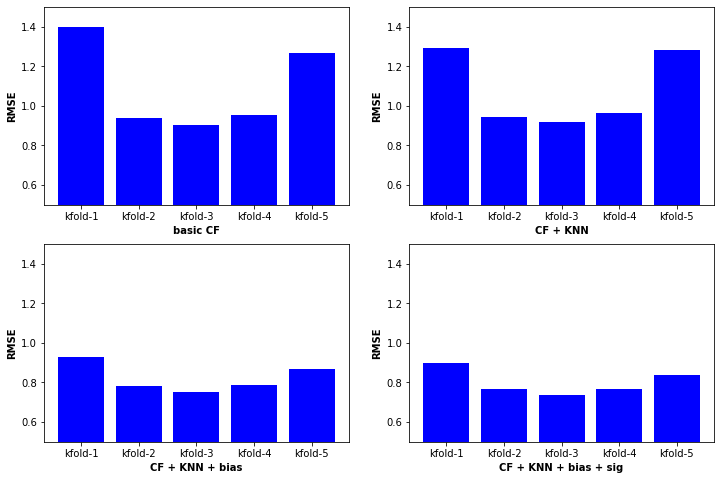

In [63]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 2, figsize=(12, 8))
labels = ['basic CF', 'CF + KNN', 'CF + KNN + bias', 'CF + KNN + bias + sig']
index = [1, 2, 3, 4, 5]
data_xticks = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

# set label of x-values 
plt.setp(ax, xticks=index, xticklabels=data_xticks)

for i in range(2):    
  for j in range(2):   
    ax[i, j].bar([1, 2, 3, 4, 5], [result for result in total_result[idx]], color='blue')
    ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
    ax[i, j].set_xlabel(f'{labels[idx]}', fontweight='bold')   # 90
    ax[i, j].set_ylabel('RMSE', fontweight='bold')
    idx += 1 

plt.show()

In [28]:
def convert_sent(point_list):
  list_p = []
  for idx, point in enumerate(point_list):
    if point < 3:
      list_p.append(0)
    else:
      list_p.append(1)
  print(len(list_p))
  return list_p

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix(model, neighbor_size=0): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model(user, item, neighbor_size) for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(1)', '실제값(0)'], columns=['예측값(1)', '예측값(0)'])
  return cmdf

In [66]:
c_matrix(CF_knn, 90)   # P = 1, N = 0 

20000
20000


,예측값(1),예측값(0)
실제값(1),2,637
실제값(0),46,19315


In [67]:
c_matrix(CF_knn_bias_sig, 90) 

20000
20000


,예측값(1),예측값(0)
실제값(1),114,525
실제값(0),73,19288


In [68]:
def recom_item(user_id, n_items, neighbor_size=30):
  ''' 
  사용자 ID, 추천 아이템 수, 이웃 크기를 넘겨 받아 
  주어진 사용자에 대한 아이템을 돌려주는 함수 
  '''   
  user_item = rating_matrix.loc[user_id].copy()   # 전체 데이터에서 현재 사용자의 평점 데이터만 골라 user_movie에 복사 
  for item in rating_matrix: 
    if pd.notnull(user_item.loc[item]):   # 현재 영화 평점이 null이 아닌 경우에는 사용자가 이미 해당 영화를 시청한 경우에 해당 
      user_item.loc[item] = 0    # 추천 리스트에서 제외하기 위해 예상 평점을 0으로 설정 
    else: 
      user_item.loc[item] = CF_knn_bias_sig(user_id, item, neighbor_size)   # 현 사용자의 예상 평점 계산 
  item_sort = user_item.sort_values(ascending=False)[:n_items]   # 영화의 예상 평점을 기준으로 영화 리스트를 내림차순으로 정렬 후 n_items 값만큼 추출 
  # print(item_sort, item_sort.index)
  recom_items = dog_item.loc[item_sort.index]   # 추출된 영화 정보 저장 
  recommendations = recom_items['goodsnm']    # 추출된 영화 정보에서 제목을 추출해 반환 
  return recommendations

In [69]:
recom_item(user_id=98380, n_items=5, neighbor_size=135)

goodsno
41059       지엠펫 메쉬 반사 하네스 세트 브라운
27179         브리더 타원 캐릭터 장난감 개구리
67750      흡수혁명 애견패드 소형 50매 3개묶음
26067    풀무원 아미오 유산균 담은 닭가슴살 50g
787              옥시그린 점성 젤 118ml
Name: goodsnm, dtype: object